In [28]:
from __future__ import print_function
from __future__ import division
import numpy as np
import torch
import math
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
import torch.nn as nn
import torch.nn.functional as F
import time
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import scipy.sparse as sp
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix
from scipy.sparse import diags
from scipy.sparse import eye
from pathlib import Path
from functools import partial
import pickle


In [29]:
device = device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [30]:
!wget https://github.com/gyy1225/dblp_gcn/raw/master/data/dblp/edges.pkl
!wget https://github.com/gyy1225/dblp_gcn/raw/master/data/dblp/labels.pkl

--2024-09-24 11:48:57--  https://github.com/gyy1225/dblp_gcn/raw/master/data/dblp/edges.pkl
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/gyy1225/dblp_gcn/master/data/dblp/edges.pkl [following]
--2024-09-24 11:48:57--  https://raw.githubusercontent.com/gyy1225/dblp_gcn/master/data/dblp/edges.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1110741 (1.1M) [application/octet-stream]
Saving to: ‘edges.pkl.2’

edges.pkl.2         100%[===================>]   1.06M  --.-KB/s    in 0.04s   

2024-09-24 11:48:57 (27.6 MB/s) - ‘edges.pkl.2’ saved [1110741/1110741]

--2024-09-24 11:48:57--  https://

In [31]:
# load data

def normalize(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1),dtype=np.float32)
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx

def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)



"""Load citation network dataset (dblp only for now)"""
adj_file=open('edges.pkl','rb')
label_file=open('labels.pkl','rb')
adj_list=pickle.load(adj_file)
labels_list=pickle.load(label_file)
adj=adj_list[0]+adj_list[1]+adj_list[2]+adj_list[3]
label=labels_list[0]+labels_list[1]+labels_list[2]
labels=np.array(label)


<ipython-input-31-2e86851775c8>:26: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  adj_list=pickle.load(adj_file)
<ipython-input-31-2e86851775c8>:26: DeprecationWarning: Please import `csc_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csc` namespace is deprecated and will be removed in SciPy 2.0.0.
  adj_list=pickle.load(adj_file)


In [32]:
# build symmetric adjacency matrix
adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

In [33]:
adj = normalize(adj + sp.eye(adj.shape[0])) #Normalizing for removing gradient vanishing and exploding problem

In [34]:
idx = np.array(labels[:, 0], dtype=np.int32)
idx_train = range(0,2400)
idx_val = range(2400, 3200)
idx_test = range(3200, 4000)
idx_train = torch.LongTensor(idx_train)
idx_val = torch.LongTensor(idx_val)
idx_test = torch.LongTensor(idx_test)

In [35]:
labels = torch.LongTensor(labels[:, -1])
adj = sparse_mx_to_torch_sparse_tensor(adj)

In [36]:
adj = adj.to(device)
labels = labels.to(device)
idx_train = idx_train.to(device)
idx_val = idx_val.to(device)
idx_test = idx_test.to(device)

In [37]:
class LightGCN(nn.Module):
    def __init__(self, num_nodes, embedding_dim, num_layers, num_classes):
        super(LightGCN, self).__init__()

        self.embedding = nn.Embedding(num_nodes, embedding_dim)
        self.num_layers = num_layers
        self.classifier = nn.Linear(embedding_dim, num_classes)
        nn.init.normal_(self.embedding.weight, std=0.1)

    def forward(self, adj):
        x = self.embedding.weight
        for _ in range(self.num_layers):
            x = torch.spmm(adj, x)  # Sparse matrix multiplication

        x = self.classifier(x)

        return F.log_softmax(x, dim=1)

In [38]:
n_labels = labels.max().item() + 1
n_nodes = len(adj)
n_labels

4

In [39]:
torch.manual_seed(34)

model = LightGCN(num_nodes=n_nodes,
                 embedding_dim=64,
                 num_layers=2,
                 num_classes=n_labels)
optimizer = optim.Adam(model.parameters(),
                       lr=0.001, weight_decay=5e-4)


model = model.to(device)

def step():
    t = time.time()
    model.train()
    optimizer.zero_grad()
    output = model(adj)
    loss = F.nll_loss(output[idx_train], labels[idx_train])
    acc = accuracy(output[idx_train], labels[idx_train])
    loss.backward()
    optimizer.step()

    return loss.item(), acc

def evaluate(idx):
    model.eval()
    output = model(adj)
    loss = F.nll_loss(output[idx], labels[idx])
    acc = accuracy(output[idx], labels[idx])

    return loss.item(), acc

In [40]:
def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)

In [41]:
epochs = 1000
print_steps = 100
train_loss, train_acc = [], []
val_loss, val_acc = [], []

for i in tqdm(range(epochs)):
    tl, ta = step()
    train_loss += [tl]
    train_acc += [ta]

    if((i+1)%print_steps) == 0 or i == 0:
        tl, ta = evaluate(idx_train)
        vl, va = evaluate(idx_val)
        val_loss += [vl]
        val_acc += [va]

        print('Epochs: {}, Train Loss: {:.3f}, Train Acc: {:.3f}, Validation Loss: {:.3f}, Validation Acc: {:.3f}'.format(i, tl, ta, vl, va))

  1%|▏         | 14/1000 [00:02<01:48,  9.10it/s]

Epochs: 0, Train Loss: 1.392, Train Acc: 0.237, Validation Loss: 1.388, Validation Acc: 0.269


 12%|█▏        | 121/1000 [00:02<00:07, 116.17it/s]

Epochs: 99, Train Loss: 1.053, Train Acc: 0.960, Validation Loss: 1.161, Validation Acc: 0.906


 23%|██▎       | 230/1000 [00:03<00:04, 162.90it/s]

Epochs: 199, Train Loss: 0.497, Train Acc: 0.983, Validation Loss: 0.715, Validation Acc: 0.924


 33%|███▎      | 326/1000 [00:03<00:03, 186.07it/s]

Epochs: 299, Train Loss: 0.265, Train Acc: 0.988, Validation Loss: 0.445, Validation Acc: 0.936


 43%|████▎     | 428/1000 [00:04<00:02, 198.17it/s]

Epochs: 399, Train Loss: 0.176, Train Acc: 0.990, Validation Loss: 0.324, Validation Acc: 0.936


 53%|█████▎    | 532/1000 [00:04<00:02, 200.89it/s]

Epochs: 499, Train Loss: 0.133, Train Acc: 0.993, Validation Loss: 0.267, Validation Acc: 0.936


 64%|██████▎   | 637/1000 [00:05<00:01, 201.85it/s]

Epochs: 599, Train Loss: 0.108, Train Acc: 0.995, Validation Loss: 0.236, Validation Acc: 0.935


 72%|███████▏  | 722/1000 [00:05<00:01, 203.51it/s]

Epochs: 699, Train Loss: 0.093, Train Acc: 0.995, Validation Loss: 0.218, Validation Acc: 0.936


 82%|████████▎ | 825/1000 [00:06<00:00, 196.70it/s]

Epochs: 799, Train Loss: 0.083, Train Acc: 0.997, Validation Loss: 0.207, Validation Acc: 0.935


 93%|█████████▎| 930/1000 [00:06<00:00, 201.99it/s]

Epochs: 899, Train Loss: 0.075, Train Acc: 0.997, Validation Loss: 0.199, Validation Acc: 0.936


100%|██████████| 1000/1000 [00:07<00:00, 138.00it/s]

Epochs: 999, Train Loss: 0.070, Train Acc: 0.997, Validation Loss: 0.194, Validation Acc: 0.938


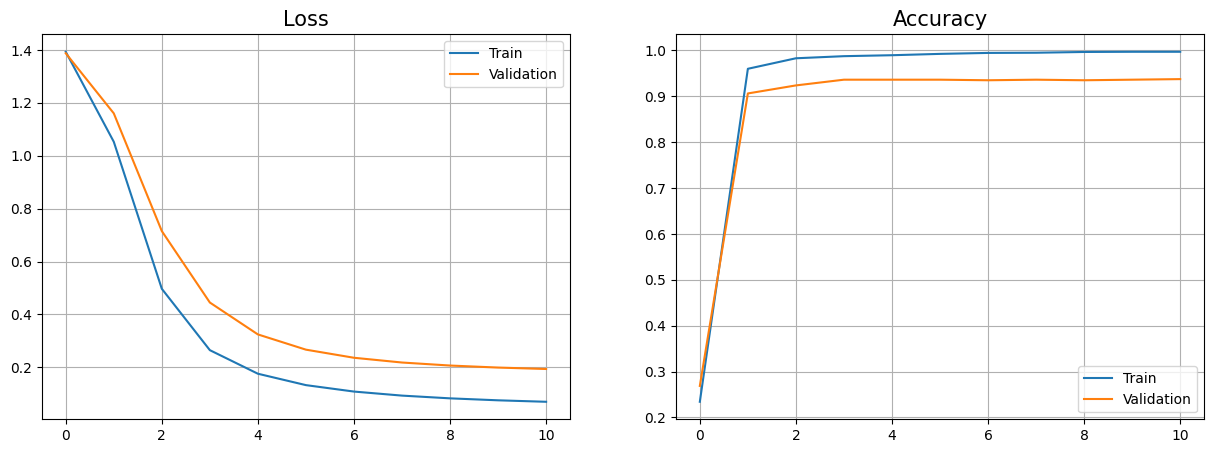

In [42]:
fig, axes = plt.subplots(1,2, figsize=(15,5))

ax = axes[0]
axes[0].plot(train_loss[::print_steps] + [train_loss[-1]], label='Train')
axes[0].plot(val_loss, label='Validation')
train_acc_cpu = [t.cpu().numpy() if isinstance(t, torch.Tensor) else t for t in train_acc]
val_acc_cpu = [t.cpu().numpy() if isinstance(t, torch.Tensor) else t for t in val_acc]
axes[1].plot(train_acc_cpu[::print_steps] + [train_acc_cpu[-1]], label='Train')
axes[1].plot(val_acc_cpu, label='Validation')
axes[0].grid()
axes[1].grid()

for ax, t in zip(axes, ['Loss','Accuracy']):
    ax.legend(), ax.set_title(t, size=15)

In [43]:
output = model(adj)

In [44]:
samples = 10
idx_sample = idx_test[torch.randperm(len(idx_test))[:samples]]

idx2lbl = {v:k for k,v in lbl2idx.items()}
df = pd.DataFrame({'Real': [idx2lbl[e] for e in labels[idx_sample].tolist()],
                   'Pred': [idx2lbl[e] for e in output[idx_sample].argmax(1).tolist()]})
df

NameError: name 'lbl2idx' is not defined